<a id="toc"></a>

# <p style="background-color: #008080; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:5px 5px;">Auto Scout Car Prices Prediction Project: <br> Modeling, Model-Selection, and Feature-Selection </p>

## <p style="background-color: #008080; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:center; border-radius:10px 10px;">Content</p>

* [INTRODUCTION NOTEBOOK](00_introduction.ipynb)
* [IMPORTING LIBRARIES NEEDED IN THIS NOTEBOOK](#1)
* [FUNCTIONS](#fn)
* [MODELING](#2A)
* * I am going to try many models: linear OLS, poly OLS, lasso, ridge, Random Forest, SGDregression, XGB, light GBM, catBoost.
* [MODEL-SELECTION](#2B)
* * I will drop the worst performing ones.
* [FEATURE-SELECTION](#2C)
* * I'll keep only about 10 of the features from the current dataset.
* [THE END OF MODELING](#3)

<a id="1"></a>

## Importing Libraries

In [1]:
from catboost import CatBoostRegressor
import numpy as np
from lightgbm import LGBMRegressor, plot_importance
import matplotlib.pyplot as plt
import pandas as pd
import regex as re
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from time import perf_counter
from xgboost import XGBRegressor

<a id='fn'></a>
## Functions

In [2]:
def make_results_table(models,X_train_tr, y_train, X_test_tr, y_test):
    '''
    input: dict of models(name: model, X_train_tr, y_train, X_test_tr, y_test
    output: dataframe of model and their performance scores.
    '''
    results = pd.DataFrame(columns = ['model','score(r2)', 'rmse', 'mae', 'time'])
    for name in models.keys():
        print(name)
        t0 = perf_counter()
        model = models[name]
        row = {}
        row['model'] = [name]
        model.fit(X_train_tr, y_train)
        row['score(r2)'] = [model.score(X_test_tr, y_test)]
        y_test_hat = model.predict(X_test_tr)
        row['rmse'] = [int((mean_squared_error(y_test, y_test_hat))**(1/2))]
        row['mae'] = [int(mean_absolute_error(y_test, y_test_hat))]
        t1 = perf_counter()
        row['time'] = t1 - t0
        row = pd.DataFrame(row)
        results = pd.concat([results, row], ignore_index=True)
        models[name] = model
    return results, models

In [3]:
def make_results_table_with_cv(models,df2,rep=10):
    '''
    input: dict of models(name: model, X_train_tr, y_train, X_test_tr, y_test
    output: dataframe of model and their performance scores.
    '''
    results = pd.DataFrame(columns = ['model','score(r2)', 'rmse', 'mae', 'time'])
    for i in range(rep):
        X = df2.drop('price',axis=1)
        y = df2.price
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
        num_transformer = StandardScaler()
        preprocessor = ColumnTransformer(
                transformers=[
                    ('num', num_transformer, num_cols)
                ], remainder='passthrough')
        X_train_tr = preprocessor.fit_transform(X_train)
        X_test_tr = preprocessor.transform(X_test)
        for name in models.keys():
            print(name)
            t0 = perf_counter()
            model = models[name]
            row = {}
            row['model'] = [name]
            model.fit(X_train_tr, y_train)
            row['score(r2)'] = [model.score(X_test_tr, y_test)]
            y_test_hat = model.predict(X_test_tr)
            row['rmse'] = [int((mean_squared_error(y_test, y_test_hat))**(1/2))]
            row['mae'] = [int(mean_absolute_error(y_test, y_test_hat))]
            t1 = perf_counter()
            row['time'] = t1 - t0
            row = pd.DataFrame(row)
            results = pd.concat([results, row], ignore_index=True)
            models[name] = model
            
    meta = pd.DataFrame(columns = ['model', 'score(r2)_mean','score(r2)_sd', 'rmse_mean', 'rmse_sd', 'mae_mean', 'mae_sd','time_mean', 'time_sd'])
    meta['model'] = results.model.unique()
    for name in meta.model:
        for s in ["score(r2)", "rmse", "mae", "time"]:
            tmean = s+'_mean'
            meta.loc[results.model==name,tmean] = results[results.model==name][s].mean()
            tsd = s+'_sd'
            m = meta.loc[results.model==name,tmean]
            sd = sum([(x-m)**2 for x in results[results.model==name][s]])**(1/2)
            meta.loc[results.model==name,tsd] = sd
    colnames = list(X_train.columns)
    return meta, models, colnames

<a id="2A"></a>
## Modeling

In [4]:
df = pd.read_json('data_post03.json', lines=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15884 entries, 0 to 15883
Columns: 188 entries, make_model to saf_central_door_lock
dtypes: bool(65), float64(5), int64(103), object(15)
memory usage: 15.9+ MB


In [6]:
cat_cols = ['make_model', 'body_type','prev_owner','type', 'body_color',
           'paint_type', 'nr_doors', 'nr_seats', 'gearing_type', 'drive_chain', 'fuel', 
            'country_version', 'upholstery_material', 'upholstery_color', 'emission_class', 'gears', 'cylinders']
df = df.drop(cat_cols, axis=1)

In [7]:
vat = df['vat_deductible']

In [8]:
df = df.drop(['consumption_city','consumption_country','vat_deductible'], axis=1)

In [9]:
df['vat_deductible'] = vat

In [10]:
df.columns[:15]

Index(['price', 'km', 'hp', 'displacement', 'weight', 'co2_emission',
       'warranty_mo', 'consumption_comb', 'age', 'make_model_audi_a3',
       'make_model_opel_astra', 'make_model_opel_corsa',
       'make_model_opel_insignia', 'make_model_renault_clio',
       'make_model_renault_espace'],
      dtype='object')

In [11]:
num_cols = ['km', 'age', 'hp', 'displacement', 'weight', 'co2_emission',
       'warranty_mo', 'consumption_comb']

### Linear without polynomial features
#### preliminary work - train and test split

In [12]:
X = df.drop('price',axis=1)
y = df.price

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [14]:
num_transformer = StandardScaler()

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols)
    ], remainder='passthrough')

In [16]:
X_train_tr = preprocessor.fit_transform(X_train)

In [17]:
X_test_tr = preprocessor.transform(X_test)

#### Linear OLS

In [18]:
ols = LinearRegression()

In [19]:
ols.fit(X_train_tr, y_train)

LinearRegression()

In [20]:
ols.score(X_test_tr, y_test)

0.8961436660199453

In [21]:
y_test_hat = ols.predict(X_test_tr)
(mean_squared_error(y_test, y_test_hat))**(1/2)

2370.724903561772

#### Linear Ridge

In [22]:
ridge = Ridge()

In [23]:
ridge.fit(X_train_tr,y_train)

Ridge()

In [24]:
ridge.score(X_test_tr,y_test)

0.8962792549393883

In [25]:
y_test_hat = ridge.predict(X_test_tr)
(mean_squared_error(y_test, y_test_hat))**(1/2)

2369.176856375111

### Adding polynomial features
* polynomial (deg 2) has no observable effect on scores for OLS or Ridge

In [26]:
poly = PolynomialFeatures(degree=2)

In [27]:
preprocessor2 = ColumnTransformer(
    transformers=[
        ('poly', poly, ['warranty_mo']),
        ('num', num_transformer, num_cols)
    ], remainder='passthrough')

# for poly, I also ried 'hp', 'km', 'consumption_comb', etc, 
# for which the objective functions does not converge

In [28]:
X_train_tr2 = preprocessor2.fit_transform(X_train)
X_test_tr2 = preprocessor2.transform(X_test)

#### Poly OLS

In [29]:
ols2 = LinearRegression()

In [30]:
ols2.fit(X_train_tr2, y_train)

LinearRegression()

In [31]:
ols2.score(X_test_tr2, y_test)

0.8962385053827131

In [32]:
y_test_hat = ols2.predict(X_test_tr2)
(mean_squared_error(y_test, y_test_hat))**(1/2)

2369.6422089234475

#### Poly Ridge

In [33]:
ridge2 = Ridge()

In [34]:
ridge2.fit(X_train_tr2,y_train)

Ridge()

In [35]:
ridge2.score(X_test_tr2,y_test)

0.8963741441119741

In [36]:
y_test_hat = ridge2.predict(X_test_tr2)
(mean_squared_error(y_test, y_test_hat))**(1/2)

2368.0928848329263

### Preliminary Comparative Performance of 6 Models

* I have created a function to build a dataframe of performance metrics of the models
* The performance metrics I have chosen for comaprison at this first stage elimination are: score(r2), rmse, mae, and performance time

In [37]:
models = {}

In [38]:
ols = LinearRegression()
models['OLS'] = ols

In [39]:
lasso = Lasso()
models['Lasso'] = lasso

In [40]:
ridge = Ridge()
models['Ridge'] = ridge

In [41]:
sgd = SGDRegressor()
models['SGD'] = sgd

In [42]:
xgb = XGBRegressor()
models['XGB'] = xgb

In [43]:
rf = RandomForestRegressor()
models['RF'] = rf

In [44]:
lgbm = LGBMRegressor()
models['LGBM'] = lgbm

In [45]:
cb = CatBoostRegressor(verbose=False)
models['CatBoost'] = cb

In [46]:
results, models = make_results_table(models,X_train_tr, y_train, X_test_tr, y_test)

OLS
Lasso


/var/folders/2j/b9jb3rl94dj00vyj27s7v1qm0000gn/T/ipykernel_5201/2448430512.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, row], ignore_index=True)


Ridge
SGD
XGB
RF
LGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1170
[LightGBM] [Info] Number of data points in the train set: 12707, number of used features: 156
[LightGBM] [Info] Start training from score 18054.084678
CatBoost


<a id="2B"></a>
## Model-Selection

* I can easily reject OLS, Ridge, and SGD based on their performance scores.
* RF takes way too much time for a modest gain.
* For feature selection I will only use XGB, LGBM, catBoost

In [47]:
results

,model,score(r2),rmse,mae,time
0,OLS,0.896144,2370,1654,0.269461
1,Lasso,0.896692,2364,1648,0.670616
2,Ridge,0.896279,2369,1653,0.198306
3,SGD,0.894653,2387,1658,0.743663
4,XGB,0.958985,1489,905,0.536306
5,RF,0.951462,1620,857,24.585263
6,LGBM,0.955930,1544,976,0.462867
7,CatBoost,0.965750,1361,889,8.990538


## Feature Selection

* I have trained models stored in the dicionary models.
* I will use that to observe the feature importance

### XGB

In [48]:
xgb = models['XGB']

<Axes: >

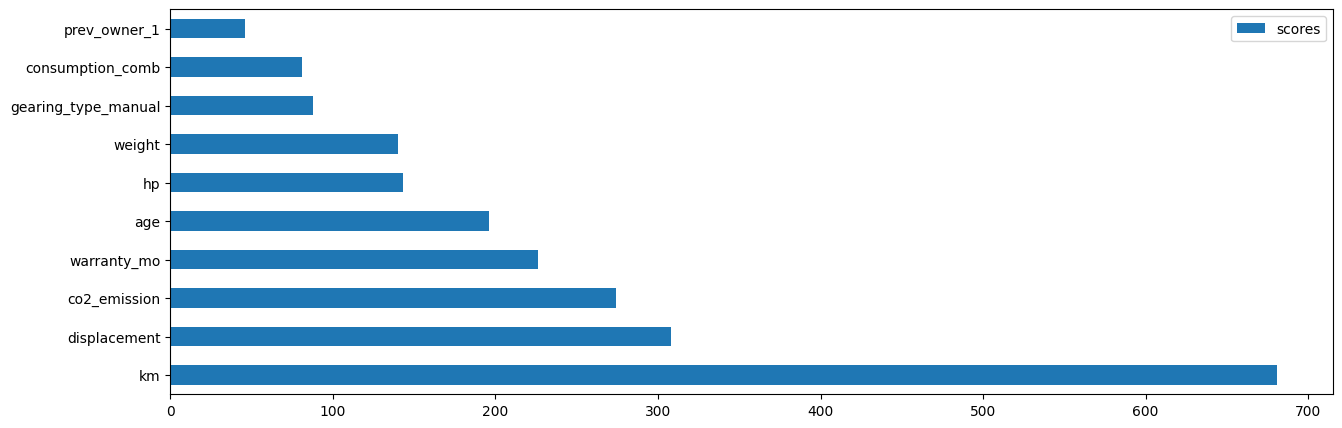

In [49]:
feature_importance = xgb.get_booster().get_score(importance_type='weight')
values = list(feature_importance.values())
keys = [X_train.columns[int(re.sub('f','',x))] for x in feature_importance.keys()]
data = pd.DataFrame(data=values, index=keys, columns=["scores"]).sort_values(by = "scores", ascending=True)
data.nlargest(10, columns="scores").plot(kind='barh', figsize = (15,5)) ## plot top 15 features

In [50]:
xgb_cols = set(data.nlargest(10, columns="scores").index)
xgb_cols

{'age',
 'co2_emission',
 'consumption_comb',
 'displacement',
 'gearing_type_manual',
 'hp',
 'km',
 'prev_owner_1',
 'warranty_mo',
 'weight'}

### LGBM

In [51]:
lgbm = models['LGBM']

<Axes: >

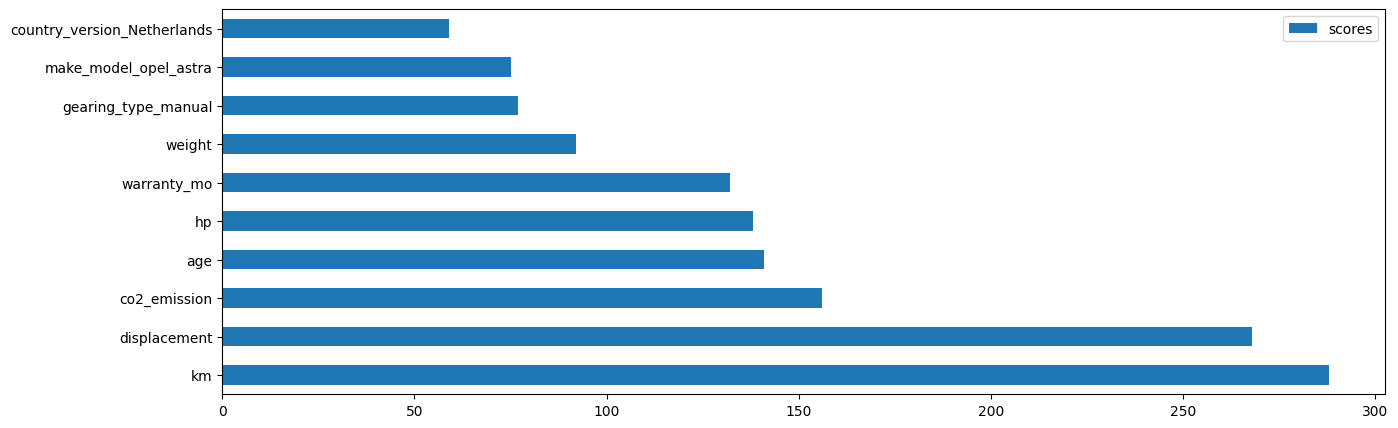

In [52]:
feature_importance = list(lgbm.feature_importances_)
values = list(feature_importance)
keys = list(X_train.columns)
data = pd.DataFrame(data=values, index=keys, columns=["scores"]).sort_values(by = "scores", ascending=True)
data.nlargest(10, columns="scores").plot(kind='barh', figsize = (15,5)) ## plot top 10 features

In [53]:
lgbm_cols = set(data.nlargest(10, columns="scores").index)
lgbm_cols

{'age',
 'co2_emission',
 'country_version_Netherlands',
 'displacement',
 'gearing_type_manual',
 'hp',
 'km',
 'make_model_opel_astra',
 'warranty_mo',
 'weight'}

### catBoost

In [54]:
cb = models['CatBoost']

<Axes: >

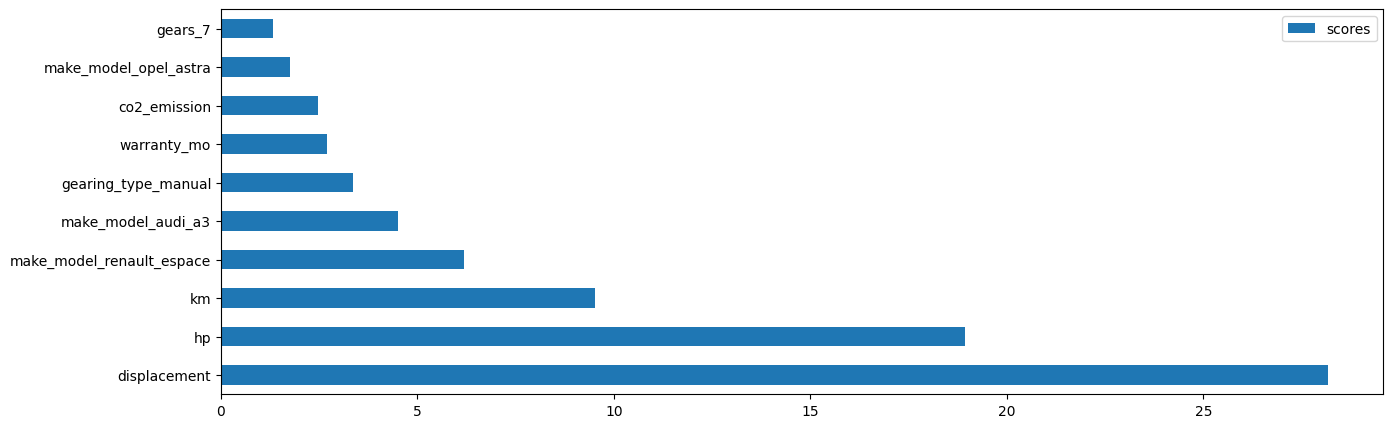

In [55]:
feature_importance = list(cb.feature_importances_)
values = list(feature_importance)
keys = list(X_train.columns)
data = pd.DataFrame(data=values, index=keys, columns=["scores"]).sort_values(by = "scores", ascending=True)
data.nlargest(10, columns="scores").plot(kind='barh', figsize = (15,5)) ## plot top 15 features

In [56]:
cb_cols = set(data.nlargest(10, columns="scores").index)
cb_cols

{'co2_emission',
 'displacement',
 'gearing_type_manual',
 'gears_7',
 'hp',
 'km',
 'make_model_audi_a3',
 'make_model_opel_astra',
 'make_model_renault_espace',
 'warranty_mo'}

In [57]:
good_cols = xgb_cols.union(lgbm_cols).union(cb_cols)

In [58]:
good_cols.add('price')

In [59]:
len(good_cols), good_cols

(16,
 {'age',
  'co2_emission',
  'consumption_comb',
  'country_version_Netherlands',
  'displacement',
  'gearing_type_manual',
  'gears_7',
  'hp',
  'km',
  'make_model_audi_a3',
  'make_model_opel_astra',
  'make_model_renault_espace',
  'prev_owner_1',
  'price',
  'warranty_mo',
  'weight'})

## Model Selection Using Selected Features

In [60]:
num_cols = ['km', 'hp', 'displacement', 'weight', 'co2_emission', 'warranty_mo', 'consumption_comb']
sel_cols = num_cols.copy()
for i in good_cols:
    if i not in set(num_cols):
        sel_cols.append(i)

In [61]:
sel_cols

['km',
 'hp',
 'displacement',
 'weight',
 'co2_emission',
 'warranty_mo',
 'consumption_comb',
 'price',
 'prev_owner_1',
 'gearing_type_manual',
 'make_model_opel_astra',
 'gears_7',
 'make_model_audi_a3',
 'country_version_Netherlands',
 'age',
 'make_model_renault_espace']

In [62]:
df.columns

Index(['price', 'km', 'hp', 'displacement', 'weight', 'co2_emission',
       'warranty_mo', 'consumption_comb', 'age', 'make_model_audi_a3',
       ...
       'saf_led_headlights', 'saf_passenger-side_airbag',
       'saf_xenon_headlights', 'saf_night_view_assist', 'saf_head_airbag',
       'saf_emergency_brake_assistant', 'saf_driver-side_airbag',
       'saf_lane_departure_warning_system', 'saf_central_door_lock',
       'vat_deductible'],
      dtype='object', length=169)

In [63]:
df2 = df[sel_cols]

In [64]:
df2.columns

Index(['km', 'hp', 'displacement', 'weight', 'co2_emission', 'warranty_mo',
       'consumption_comb', 'price', 'prev_owner_1', 'gearing_type_manual',
       'make_model_opel_astra', 'gears_7', 'make_model_audi_a3',
       'country_version_Netherlands', 'age', 'make_model_renault_espace'],
      dtype='object')

## Cross Validation (10 reps) and Final Model Selection

In [65]:
models = {}
xgb = XGBRegressor()
models['XGB'] = xgb
lgbm = LGBMRegressor()
models['LGBM'] = lgbm
cb = CatBoostRegressor(verbose=False)
models['CatBoost'] = cb

In [66]:
meta, models, colnames = make_results_table_with_cv(models,df2)

XGB


/var/folders/2j/b9jb3rl94dj00vyj27s7v1qm0000gn/T/ipykernel_5201/2981609376.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, row], ignore_index=True)


LGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 883
[LightGBM] [Info] Number of data points in the train set: 12707, number of used features: 15
[LightGBM] [Info] Start training from score 17990.483041
CatBoost
XGB
LGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 12707, number of used features: 15
[LightGBM] [Info] Start training from score 18027.851027
CatBoost
XGB
LGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000805 seconds.
You can set `force_row_wise=true` to 

In [67]:
meta

,model,score(r2)_mean,score(r2)_sd,rmse_mean,rmse_sd,mae_mean,mae_sd,time_mean,time_sd
0,XGB,0.942319,0.01498,1792.0,220.11815,1092.8,96.372195,0.306567,0.236664
1,LGBM,0.936028,0.015365,1887.6,229.020523,1177.8,83.316265,0.182088,0.050847
2,CatBoost,0.942925,0.013423,1783.0,213.138453,1108.6,94.310127,2.416431,0.77304


## Conclusion
* XGB is the best model for our purpose. Faster than the other two and more accurate that LGBM
* The features I am going to focus on are the following: 
* * ['co2_emission', 'com_hill_holder', 'com_multi-function_steering_wheel', 'consumption_comb', 'displacement', 'hp', 'km', 'saf_xenon_headlights', 'warranty_mo', 'weight']

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a>

<a id="3"></a>
## End of Modeling

## Next: [Parameter Selection](05_parameter_selection.ipynb)